# Notebook to query GALEX field and visit information

In [1]:
GALEX_FOV_DIAM = 1.0
exp_mean_min = 800
nr_vis_min = 10 #  >=
surveys =  ["MIS","DIS"] # "AIS",,"CAI" ,"NGS", ,"GII"
fout_name = "none"
fout_name = "./resources/GALEX_field_id_lists/field_ids_"+''.join(surveys)+"_exp"+str(exp_mean_min)+"_vis"+str(nr_vis_min)+".yaml"  # No file written for "none"

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.table import unique, Table, join, unique
from astropy import units as uu
from astropy.coordinates import SkyCoord
import healpy as hpy
import numpy as np
from vasca.resource_manager import ResourceManager

### Get TDS field info from astroquery

In [3]:
#Get TDS field info
tt_tds = Table.read("./resources/TDS-ApJ_766_60/tds_fields_table2.ecsv")
dd_query = {"instrument_name":"GALEX",
             "dataproduct_type":"image",
             "dataRights":"PUBLIC",
             "filters":"NUV",
             "target_name":tt_tds["name"]}
# "coordinates":tt_tds["coordinates"], "radius":".02 deg",

tt_obs = Observations.query_criteria(**dd_query)
display(tt_obs[:2])

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str5,str3,str5,str3,str3,str2,str16,str1,str19,float64,float64,str5,str1,int64,float64,float64,float64,float64,float64,str1,float64,str1,str3,int64,str43,str130,str124,str6,bool,float64,str4,str4
science,GALEX,DIS,GALEX,DIS,NUV,UV,PS_XMMLSS_MOS00,--,2592597978464124928,35.578863351058885,-3.14176421214975,image,--,2,54791.262777777774,55512.31023148148,40457.25,169300000000.0,300700000000.0,--,55953.94460633,--,DIS,--,CIRCLE ICRS 35.57886335 -3.14176421 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS00-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/PS_XMMLSS_MOS00-nd-exp.fits.gz,PUBLIC,--,5885.0,2047,3659
science,GALEX,DIS,GALEX,DIS,NUV,UV,PS_XMMLSS_MOS01,--,2592668347208302592,36.49984981667359,-3.4923125504146,image,--,2,54791.33122685185,55512.37857638889,38609.0,169300000000.0,300700000000.0,--,55953.94680547,--,DIS,--,CIRCLE ICRS 36.49984982 -3.49231255 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS01-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/PS_XMMLSS_MOS01-nd-exp.fits.gz,PUBLIC,--,5885.0,2048,3661


### Get all-sky visit and field information

In [4]:
# Get visit table
rm = ResourceManager()
tt_vis = Table.read(rm.get_path("gal_visits_list", "sas_cloud"))

#Generate field info table
tt_vis_uni = unique(tt_vis, keys='ParentImgRunID')
tt_vis_uni_grp = tt_vis_uni.group_by(['ParentImgRunID'])
tt_vis_grp = tt_vis.group_by(['ParentImgRunID'])
tt_vis_mean = tt_vis_grp['ParentImgRunID',"RATileCenter","DECTileCenter","nexptime","fexptime","gall","galb"].groups.aggregate(np.mean)
tt_vis_sum = tt_vis_grp['ParentImgRunID',"nexptime","fexptime","nPhotoVisits"].groups.aggregate(np.sum)
tt_fd = join(tt_vis_mean, tt_vis_sum, keys='ParentImgRunID',table_names=['mean', 'sum'],uniq_col_name='{col_name}_{table_name}')
tt_fd = join(tt_fd, tt_vis_uni_grp['ParentImgRunID',"survey","minPhotoObsDate","maxPhotoObsDate"], keys='ParentImgRunID')
display(tt_fd[:2])

tt_vis.add_index('ParentImgRunID')
tds_idx = tt_vis.loc_indices[np.array(tt_obs["obs_id"],dtype=np.int64)]
display(tt_vis[tds_idx ][0:2])
tds_nr_flds = len(unique(tt_vis[tds_idx ], keys='ParentImgRunID'))

#Show exposure for different surveys
surveys_all =  ["AIS","MIS","DIS","NGS","GII","CAI"] 
for sur in surveys_all:
    csel = (tt_vis['survey']==sur)
    exp_sum = tt_vis[csel]['nexptime'].sum()
    print(sur,": Visits =",csel.sum(),",exposure =",int(exp_sum),"s ,exposure per visit =",int(exp_sum/csel.sum()),"s")

#Show also TDS info
tds_exp = tt_vis[tds_idx]['nexptime'].sum()
tds_nr_vis = len(tds_idx)
print("TDS : Fields =",tds_nr_flds,"Visits =",tds_nr_vis,",exposure =",int(tds_exp),"s ,exposure per visit =",int(tds_exp/tds_nr_vis),"s (part of DIS)")     


ParentImgRunID,RATileCenter,DECTileCenter,nexptime_mean,fexptime_mean,gall,galb,nexptime_sum,fexptime_sum,nPhotoVisits,survey,minPhotoObsDate,maxPhotoObsDate
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes22,bytes22
2391589660720627712,210.542232477159,-32.6804067553693,544.0,544.0,319.74270865062874,27.871918173555255,544.0,544.0,1,NGS,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM
2391624845092716544,201.528614022379,-42.9957260941383,937.0,937.0,309.64494588030084,19.423571577159674,937.0,937.0,1,NGS,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM


RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb
float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64
35.5606252902383,-3.14743664508478,DIS,1345.25,0.0,2592597841327161344,2592597978464124928,63341,8150,-999,visitI,9832,1,12/18/2009 9:09:30 AM,False,null,null,null,16,-999,12/18/2009 9:09:30 AM,12/18/2009 9:31:55 AM,null,null,55183.38159722222,169.00600771825543,-57.654641102907654
35.572681398541,-3.16989331767195,DIS,1199.35,0.0,2592597841360715776,2592597978464124928,44436,8150,-999,visitI,9249,1,12/20/2009 8:50:42 AM,False,null,null,null,17,-999,12/20/2009 8:50:42 AM,12/20/2009 9:10:41 AM,null,null,55185.36854166666,169.05021602003802,-57.66412379765083


AIS : Visits = 64375 ,exposure = 6472340 s ,exposure per visit = 100 s
MIS : Visits = 11125 ,exposure = 12199096 s ,exposure per visit = 1096 s
DIS : Visits = 9775 ,exposure = 9791687 s ,exposure per visit = 1001 s
NGS : Visits = 2457 ,exposure = 2793492 s ,exposure per visit = 1136 s
GII : Visits = 7105 ,exposure = 7944605 s ,exposure per visit = 1118 s
CAI : Visits = 6028 ,exposure = 1029497 s ,exposure per visit = 170 s
TDS : Fields = 42 Visits = 1201 ,exposure = 1616734 s ,exposure per visit = 1346 s (part of DIS)


### Define field selections and compare available data-set to TDS 

In [5]:
#Select fields
sel_fd_nexptime = tt_fd["nexptime_mean"]>exp_mean_min
sel_fd_nPhotoVisits = tt_fd["nPhotoVisits"]>nr_vis_min -0.5
sel_sur = sel_fd_nexptime*0
for sur in surveys:
    sel_sur += (tt_fd["survey"]== sur)
sel_sur = np.array(sel_sur,dtype=bool)
sel_fd = sel_fd_nexptime*sel_fd_nPhotoVisits*sel_sur
display(tt_fd[sel_fd][0:2])

#Print out besic info
sel_fd_area = sel_fd.sum() * 3.1415*(GALEX_FOV_DIAM/2.)**2
sel_fd_exp = (tt_fd[sel_fd]["nPhotoVisits"]*tt_fd[sel_fd]["nexptime_mean"]).sum()
print(f"Selected number of fields: {sel_fd.sum()} ( {round(sel_fd.sum()/tds_nr_flds,2)} times TDS )")
print(f"Selected number of visits: {tt_fd[sel_fd]['nPhotoVisits'].sum()} ( {round(tt_fd[sel_fd]['nPhotoVisits'].sum()/tds_nr_vis,2)} times TDS )")
print(f"Total selected exposure  : {round(sel_fd_exp/1e6,2)} Ms ( {round(sel_fd_exp/tds_exp,2)} times TDS )\n")
#display(tt_fd[sel_fd])

#Show exposure for different surveys
for sur in surveys:
    fsel = (tt_fd[sel_fd]['survey']==sur)
    nvis =  tt_fd[sel_fd][fsel]['nPhotoVisits'].sum()
    exp_sum = tt_fd[sel_fd][fsel]['nexptime_sum'].sum()
    print(sur,": Visits =",nvis,",exposure =",int(exp_sum),"s ,exposure per visit =",exp_sum/nvis,"s")

ParentImgRunID,RATileCenter,DECTileCenter,nexptime_mean,fexptime_mean,gall,galb,nexptime_sum,fexptime_sum,nPhotoVisits,survey,minPhotoObsDate,maxPhotoObsDate
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes22,bytes22
2509140647668088832,329.72453844982545,-30.26688502959948,1112.4810344827586,1112.3775862068965,17.66461630795234,-52.25688418344318,32261.949999999997,32258.949999999997,29,DIS,8/5/2008 1:19:14 PM,8/5/2008 1:47:28 PM
2509211016412266496,343.4870552082941,16.145174806688942,851.3958333333334,851.3958333333334,86.10530413548089,-38.18444311194017,10216.75,10216.75,12,DIS,9/29/2008 12:05:31 AM,9/29/2008 12:13:39 AM


Selected number of fields: 221 ( 5.26 times TDS )
Selected number of visits: 6813 ( 5.67 times TDS )
Total selected exposure  : 8.53 Ms ( 5.27 times TDS )

MIS : Visits = 38 ,exposure = 34578 s ,exposure per visit = 909.9657894736841 s
DIS : Visits = 6775 ,exposure = 8493023 s ,exposure per visit = 1253.5828413284132 s


In [6]:
### Write out field_id file

In [7]:
if fout_name != "none":
    ff = open(fout_name, "w")
    ll_cols = ['RATileCenter', 'DECTileCenter', 'nexptime_sum', 'fexptime_sum', 'nPhotoVisits', 'survey']
    wstr = "#"
    for col in ll_cols: wstr += " " + str(col) 
    ff.write(wstr+"\n")
    for row in tt_fd[sel_fd]:
        ff.write('- '+ str(row["ParentImgRunID"]))
        wstr = " #"
        for col in ll_cols:  wstr += " " + str(row[col])
        ff.write(wstr+"\n")
    ff.close()

### Plot some field distributions

Text(0.5, 0, 'Mean exposure time[s]')

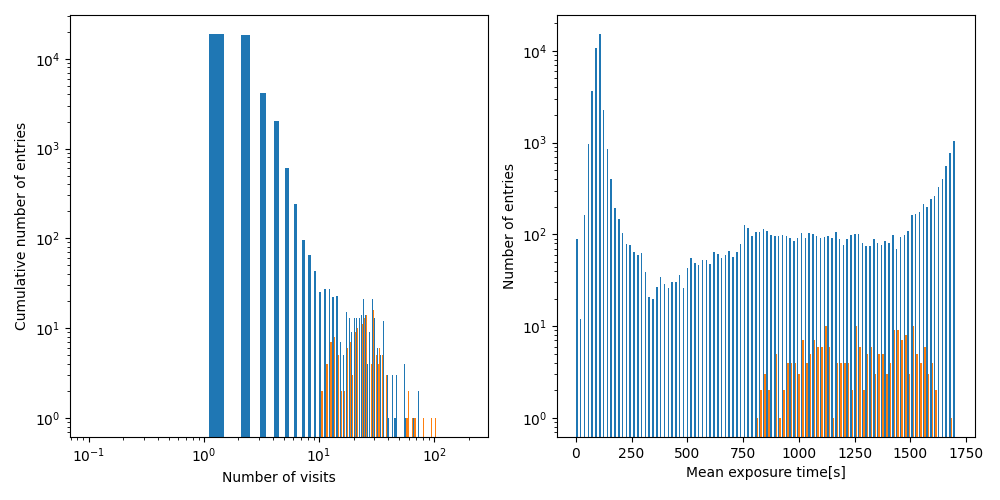

In [8]:
# Plot some field property distributions
fig, axs = plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
hist = axs[0].hist([tt_fd["nPhotoVisits"],tt_fd[sel_fd]["nPhotoVisits"]], bins= range(0,200)) #,cumulative=-1
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_ylabel("Cumulative number of entries")
axs[0].set_xlabel("Number of visits")
hist = axs[1].hist([tt_fd["nexptime_mean"],tt_fd[sel_fd]["nexptime_mean"]], bins= 100)
axs[1].set_yscale("log")
axs[1].set_ylabel("Number of entries")
axs[1].set_xlabel("Mean exposure time[s]")

### Plot coverage on the sky

High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


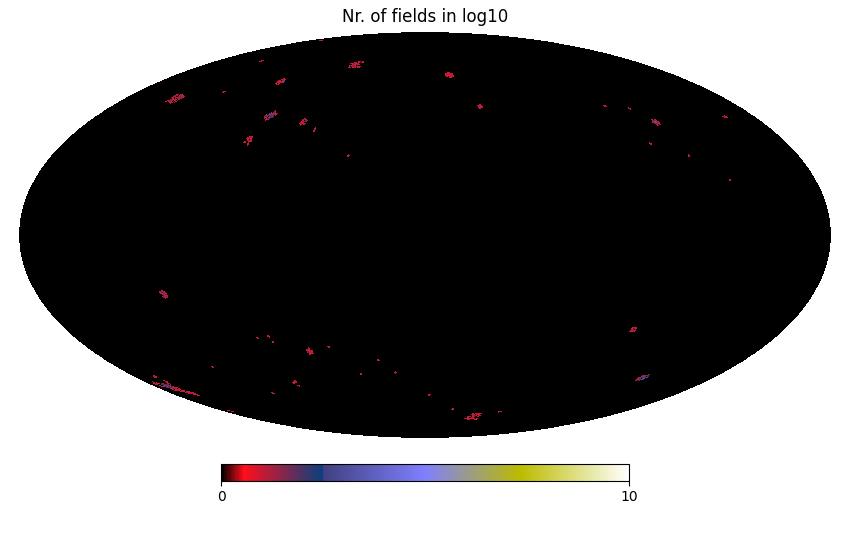

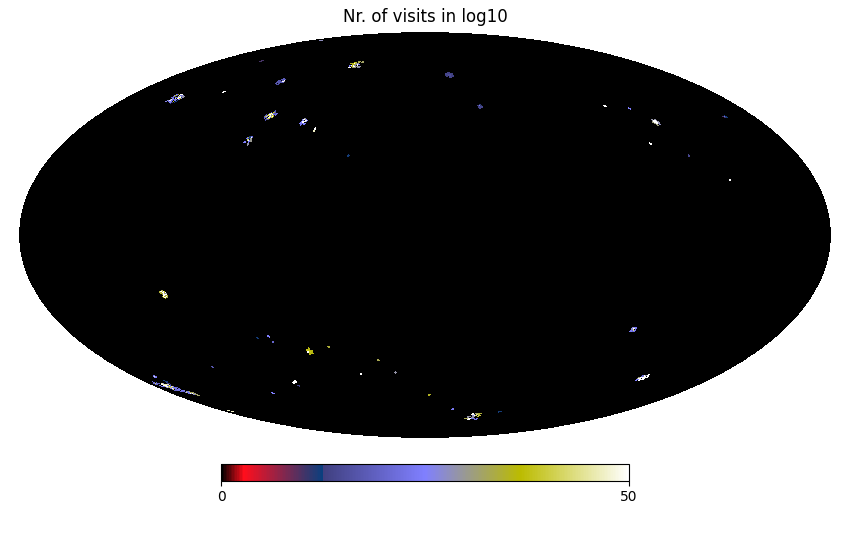

In [9]:
#Add healpix info
cosys     = "G" #"Q" for equatorial, "G" for galactic
nside     = 256
npix      = hpy.nside2npix(nside)
tt_vis["hpix"] = hpy.ang2pix(nside,tt_vis["gall"],tt_vis["galb"],lonlat=True,nest=False)

plot_sky = True
if plot_sky:
    #Setup high res plotting data
    nside_hres     = nside*16
    npix_hres = hpy.nside2npix(nside_hres)
    pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * uu.deg
    print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
    tt_fd["hvec"] = hpy.ang2vec(tt_fd["gall"],tt_fd["galb"],lonlat=True)

    nr_vis_hres = np.zeros(npix_hres)  # empty map
    nr_fd_hres = np.zeros(npix_hres)  # empty map

    # fill map with coverage data
    for fd in tt_fd[sel_fd]:
        ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV_DIAM/2.))
        nr_fd_hres[ipix_disc] += 1  # number of fields
        nr_vis_hres[ipix_disc] += fd["nPhotoVisits"]

    #Plot
    hpy.mollview(nr_fd_hres, title="Nr. of fields in log10",nest=False,cmap="gist_stern",min=0,max=10,xsize=4800)
    hpy.mollview(nr_vis_hres, title="Nr. of visits in log10",nest=False,cmap="gist_stern",min=0,max=50, xsize=4800)
    #hpy.graticule(color="white",dpar=45, dmer=60)

#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)